In [314]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from scipy import linalg as la
import scipy.stats as stats
import sympy as sy
import scipy.integrate as integrate
import scipy.special as spec

income=np.loadtxt('usincmoms.txt')
income[:,1]=income[:,1]/1000
originalincome=np.copy(income[:,0])
income[:,0]=np.append(income[:-2,0],[income[-2,0]/10,income[-1,0]/20])

# Problem 3

## Plot the histogram of US income

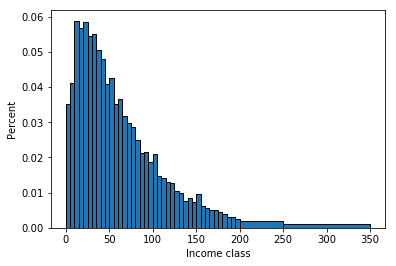

In [229]:
bins=list(range(0,205,5))+[250,350]
plt.hist(income[:,1], weights=income[:,0], bins=bins, edgecolor='black')
plt.xlabel('Income class')
plt.ylabel('Percent')
plt.show()

## LN distribution

In [469]:
inc_moments=income[:,0]
def model_moments_LN(mu, sigma):
    A=np.empty_like(inc_moments)
    for i in range(40):
        A[i]=stats.lognorm.pdf(income[:,1][i],sigma, scale=np.exp(mu))
    A[40]=stats.lognorm.pdf(income[:,1][-2], sigma, scale=np.exp(mu))
    A[41]=stats.lognorm.pdf(income[:,1][-1], sigma, scale=np.exp(mu))
    return A


In [470]:
def err_vecLN(mu, sigma, simple=False):
    if simple==True:
        return model_moments_LN(mu,sigma)-inc_moments
    else:
        return (model_moments_LN(mu,sigma)-inc_moments)/inc_moments

In [471]:
def critLN(params, *args):
    mu, sigma=params
    W=args
    err=err_vecLN(mu,sigma, False)
    return np.dot(np.dot(err.T,W),err)

In [472]:
#Solve for mu and sigma:
W=np.diag(inc_moments)
params_initLN=np.array([5, 2])
resultsLN=opt.minimize(critLN, params_initLN, args=(W), method='L-BFGS-B', bounds=((1e-9,350),(1e-9,None)))
muLN,sigmaLN=resultsLN.x
print('Estimated value of mu=',muLN,'\nEstimated value of sigma=',sigmaLN,
     '\nMinimized value of criterion funciton=',float(resultsLN.fun))

Estimated value of mu= 3.75062196967 
Estimated value of sigma= 0.706316352498 
Minimized value of criterion funciton= 0.6130014889865019


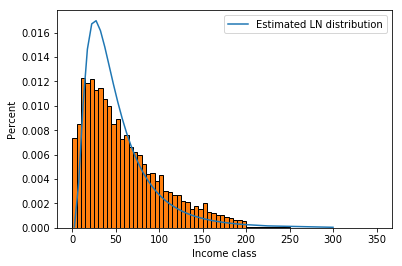

In [473]:
#Plot the histogram vs LN distribution:
plt.plot(income[:,1], stats.lognorm.pdf(income[:,1], sigmaLN, scale=np.exp(muLN)), label='Estimated LN distribution')
plt.hist(income[:,1], weights=income[:,0], bins=bins, edgecolor='black', normed=True)
plt.xlabel('Income class')
plt.ylabel('Percent')
plt.legend()
plt.show()

## GA distribution

In [478]:
def model_moments_GA(alpha, beta):
    A=np.empty_like(inc_moments)
    for i in range(40):
        A[i]=stats.gamma.pdf(income[:,1][i],alpha, scale=beta)
    A[40]=stats.gamma.pdf(income[:,1][-2],alpha, scale=beta)
    A[41]=stats.gamma.pdf(income[:,1][-1],alpha, scale=beta)
    return A

In [479]:
def err_vecGA(alpha,beta, simple=False):
    if simple==True:
        return model_moments_GA(alpha,beta)-inc_moments
    else:
        return (model_moments_GA(alpha,beta)-inc_moments)/inc_moments

In [480]:
def critGA(params,*args):
    alpha, beta=params
    W=args
    errGA=err_vecGA(alpha,beta, False)
    return np.dot(np.dot(errGA.T,W),errGA)

In [481]:
#Solve for alpha and beta:
params_initGA=np.array([3, 200])
resultsGA=opt.minimize(critGA, params_initGA, args=(W), method='L-BFGS-B', bounds=((1e-9,None),(1e-9,None)))
alphaGA,betaGA=resultsGA.x
print('Estimated value of alpha=',alphaGA,'\nEstimated value of beta=',betaGA,
     '\nMinimized value of criterion function=',float(resultsGA.fun))

Estimated value of alpha= 1.66804783006 
Estimated value of beta= 31.4986778985 
Minimized value of criterion function= 0.6055150162636782


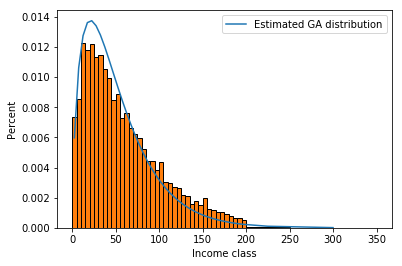

In [468]:
#Plot the histogram vs GA distribution
plt.plot(income[:,1], stats.gamma.pdf(income[:,1], alphaGA, scale=betaGA), label='Estimated GA distribution')
plt.hist(income[:,1], weights=income[:,0], bins=bins, edgecolor='black', normed=True)
plt.xlabel('Income class')
plt.ylabel('Percent')
plt.legend()
plt.show()

## Compare LN vs GA

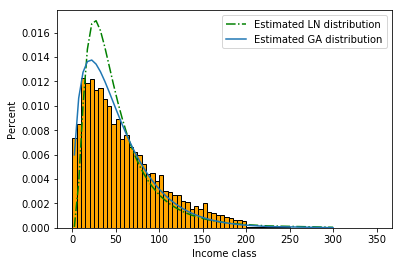

In [488]:
plt.plot(income[:,1], stats.lognorm.pdf(income[:,1], sigmaLN, scale=np.exp(muLN)), 'g-.'
         ,label='Estimated LN distribution')
plt.plot(income[:,1], stats.gamma.pdf(income[:,1], alphaGA, scale=betaGA), label='Estimated GA distribution')
plt.hist(income[:,1], weights=income[:,0], bins=bins, edgecolor='black', normed=True, facecolor='orange')
plt.xlabel('Income class')
plt.ylabel('Percent')
plt.legend()
plt.show()

The GA distribution fits the data better.

In [326]:
params_initGA=np.array([3, 200])
resultsGA2=opt.minimize(critGA, params_initGA, args=(np.eye(42)), method='L-BFGS-B', bounds=((1e-9,None),(1e-9,None)))
alphaGA2,betaGA2=resultsGA2.x

      fun: array([ 18.86443966])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -7.10542736e-07,   0.00000000e+00])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 153
      nit: 37
   status: 0
  success: True
        x: array([  7.91172835,  15.61630762])

In [339]:
sigma2=(1/42) * np.dot(np.array([err_vecGA(alphaGA2,betaGA2)]).T,np.array([err_vecGA(alphaGA2,betaGA2)]))

array([[  3.20243791e+01,   2.02914212e+01,   2.02999028e+01, ...,
          3.25293249e+00,   3.20000000e+01,   1.60000000e+01],
       [ -1.70451404e+00,   1.53809705e+00,   1.78069556e-01, ...,
         -6.74485282e-02,   1.50000000e+00,  -2.00000000e+00],
       [  2.08138861e+01,  -1.65700557e+01,   1.52310970e+01, ...,
         -5.84798130e+00,   0.00000000e+00,  -4.80000000e+01],
       ..., 
       [  7.31410812e+01,  -5.05315666e+00,   6.74310501e+01, ...,
         -9.80982012e-01,   2.56000000e+02,   6.40000000e+01],
       [ -5.41410179e-02,   1.07288846e+00,   1.46840098e+00, ...,
          1.94016909e-01,   4.00000000e+00,   0.00000000e+00],
       [ -1.72493719e+01,  -1.79262020e+01,  -4.68861861e+00, ...,
         -4.00414271e+00,  -3.20000000e+01,  -1.60000000e+01]])

# Problem 4

In [458]:
import pandas as pd

In [459]:
macro = pd.read_csv('MacroSeries.txt', sep=',', header = None)
macro.columns=['c_t','k_t','w_t','r_t']
beta=0.99
c=np.array(macro['c_t'])
k=np.array(macro['k_t'])
w=np.array(macro['w_t'])
r=np.array(macro['r_t'])

In [460]:
def getz(alpha, beta, rho, mu):
    z=np.zeros(100)
    for t in range(100):
        z[t]=np.log(w[t])-alpha*np.log(k[t])-np.log(1-alpha)
    return z

In [461]:
def model_moments(alpha, beta, rho, mu):
    z=getz(alpha, beta, rho, mu)
    moment1=np.zeros(99)
    moment2=np.zeros(99)
    moment3=np.zeros(99)
    moment4=np.zeros(99)
    for t in range(99):
        moment1[t]=z[t+1]-rho*z[t]-(1-rho)*mu
        moment2[t]=z[t]*(z[t+1]-rho*z[t]-(1-rho)*mu)
        moment3[t]=(beta*alpha*np.exp(z[t+1])*(k[t+1]**(alpha-1))*(c[t]/c[t+1]))-1
        moment4[t]=w[t]*((beta*alpha*np.exp(z[t+1])*(k[t+1]**(alpha-1))*(c[t]/c[t+1]))-1)
    return moment1, moment2, moment3, moment4

In [462]:
def critBM(params, *args):
    alpha, beta, rho, mu=params
    W=args
    m=model_moments(alpha,beta,rho,mu)
    mean1=m[0].mean()
    mean2=m[1].mean()
    mean3=m[2].mean()
    mean4=m[3].mean()
    e=np.array([mean1,mean2,mean3,mean4])
    return np.dot(np.dot(e.T,W),e)

In [492]:
params_initBM=np.array([0.5,0.75,0.8,9])
resultsBM=opt.minimize(critBM, params_initBM, args=(np.eye(4)), method='L-BFGS-B', bounds=((1e-9,1),(1e-9,1),
                                                                                         (-1,1),(1e-9,None)))
alphaBM, betaBM, rhoBM, muBM=resultsBM.x
print('Estimated values of parameters:\nalpha=',alphaBM,'\nbeta=',betaBM,'\nrho=',rhoBM,'\nmu=',muBM, 
     '\nMinimized value of criterion function=',float(resultsBM.fun))

Estimated values of parameters:
alpha= 0.492495690446 
beta= 0.738743690603 
rho= 0.8 
mu= 9.0 
Minimized value of criterion function= 0.03012967597978603
